[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Rishit-dagli/TFUG-Mysuru-2020/blob/master/TFQuantum_starter.ipynb)

# Getting started with [TensorFlow Quantum](https://www.tensorflow.org/quantum)

In this notebook you will build your first hybrid quantum classical model with 
[Cirq](https://cirq.readthedocs.io/en/stable/) and TensorFlow Quantum (TFQ). We will build a very simple model to do
binary classification in this notebook. You will then use Keras to create a wrapper for the model and simulate it to
train and evluate the model.

> Note: This notebook is designed to be run in Google Colab if you want to run it locally or on a Jupyter notebook you 
would skip the code cells with the `Colab only` comment.

## Setup

### Install TensorFlow 2.x (Colab only)

In [ ]:
# Colab only
pip install -q tensorflow==2.1.0

### Install TensorFlow Quantum (Colab only)

In [ ]:
# Colab only
pip install -q tensorflow-quantum

### Imports

Now import TensorFlow and the module dependencies:

In [1]:
import cirq
import random
import numpy as np
import sympy
import tensorflow as tf
import tensorflow_quantum as tfq

from matplotlib import pyplot as plt
from cirq.contrib.svg import SVGCircuit

### Place a qubit on the grid

You will then place a qubit on thee grid

In [2]:
qubit = cirq.GridQubit(0, 0)

## Prepare quantum data

The first thing you would do is set up the labels and parameters for preparation of the quantum data. For simplicity
here we have included just 2 data points `a` and `b`.

In [3]:
expected_labels = np.array([[1, 0], [0, 1]])

Randonly rotate `x` and `z` axis

In [4]:
angle = np.random.uniform(0, 2 * np.pi)

## Building the quantum Circuit

You will now build the quantum circuit and also convert it into a tensor

In [5]:
a = cirq.Circuit(cirq.ry(angle)(qubit))
b = cirq.Circuit(cirq.ry(angle + np.pi / 2)(qubit))
quantum_data = tfq.convert_to_tensor([a, b])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


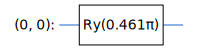

In [6]:
SVGCircuit(a)

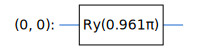

In [7]:
SVGCircuit(b)

## Building the hybrid model

This section also shows the interoperatability between TensorFlow and Cirq. With the TFQ PQC layer you can easily
embed your quantum part of the model within a standard classical Keras model.

In [8]:
q_data_input = tf.keras.Input(shape = (), dtype = tf.dtypes.string)
theta = sympy.Symbol("theta")
q_model = cirq.Circuit(cirq.ry(theta)(qubit))

In [9]:
expectation = tfq.layers.PQC(q_model, cirq.Z(qubit))
expectation_output = expectation(q_data_input)

In [10]:
classifier = tf.keras.layers.Dense(2, activation = tf.keras.activations.softmax)
classifier_output = classifier(expectation_output)

You will now define the optimizer and loss functions for your model

In [11]:
model = tf.keras.Model(inputs = q_data_input, 
                       outputs = classifier_output)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), 
              loss = tf.keras.losses.CategoricalCrossentropy())

## Traaining the model

Training the model is just like training any other Keras model and is made easy.

In [12]:
history = model.fit(x = quantum_data, 
                    y = expected_labels, 
                    epochs = 250)

Train on 2 samples
Epoch 1/250
2/2 [==============================] - 2s 1s/sample - loss: 0.6110
Epoch 2/250
2/2 [==============================] - 0s 3ms/sample - loss: 0.5516
Epoch 3/250
2/2 [==============================] - 0s 3ms/sample - loss: 0.4943
Epoch 4/250
2/2 [==============================] - 0s 3ms/sample - loss: 0.4388
Epoch 5/250
2/2 [==============================] - 0s 3ms/sample - loss: 0.3850
Epoch 6/250
2/2 [==============================] - 0s 4ms/sample - loss: 0.3356
Epoch 7/250
2/2 [==============================] - 0s 3ms/sample - loss: 0.2923
Epoch 8/250
2/2 [==============================] - 0s 2ms/sample - loss: 0.2556
Epoch 9/250
2/2 [==============================] - 0s 3ms/sample - loss: 0.2249
Epoch 10/250
2/2 [==============================] - 0s 3ms/sample - loss: 0.1994
Epoch 11/250
2/2 [==============================] - 0s 4ms/sample - loss: 0.1778
Epoch 12/250
2/2 [==============================] - 0s 3ms/sample - loss: 0.1592
Epoch 13/250
2/2 [=

## Evaluating the model

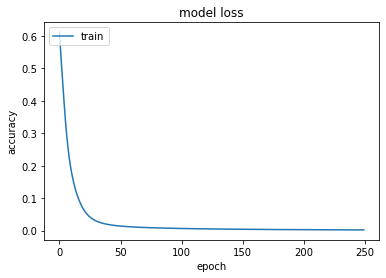

In [13]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Performing inference

In [14]:
noise = np.random.uniform(-0.25, 0.25, 2)
test_data = tfq.convert_to_tensor([
    cirq.Circuit(cirq.ry(noise[0])(qubit)),
    cirq.Circuit(cirq.ry(noise[1] + np.pi/2)(qubit)),    
])

You can see in the below cell that our model does a good job with this data though it was very easy.

In [15]:
predictions = model.predict(test_data)
predictions

array([[0.9986753 , 0.00132466],
       [0.97574824, 0.02425182]], dtype=float32)